# Main processing pipeline

## Arguments

model :
Path to object detection model

input :
Path to input image (TODO: accept video)

slicing options :
'standard', 'slice4' or 'slice16'
Standard performs standard inference and outputs the results along with bounding boxes.
Slice4 will slice the image 

In [ ]:
from ultralytics import RTDETR

#default: stored in the same directory as this script
model2 = RTDETR('bestRefinedAABB.pt')

inputPath = ('1aviframe0.jpg')





image 1/1 c:\Users\Paal\Forskningv2\Forskningv2\pipeline-v1\output_results\slices\slice_01.jpg: 640x640 12 normal_sperms, 591.8ms
Speed: 2.5ms preprocess, 591.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to output_results\processed_slices\slice_01
1 label saved to output_results\processed_slices\slice_01\labels

image 1/1 c:\Users\Paal\Forskningv2\Forskningv2\pipeline-v1\output_results\slices\slice_02.jpg: 640x640 16 normal_sperms, 610.2ms
Speed: 2.6ms preprocess, 610.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to output_results\processed_slices\slice_02
1 label saved to output_results\processed_slices\slice_02\labels

image 1/1 c:\Users\Paal\Forskningv2\Forskningv2\pipeline-v1\output_results\slices\slice_03.jpg: 640x640 12 normal_sperms, 625.8ms
Speed: 1.5ms preprocess, 625.8ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)
Results saved to output_results\processed_slices\slice_03
1 label s

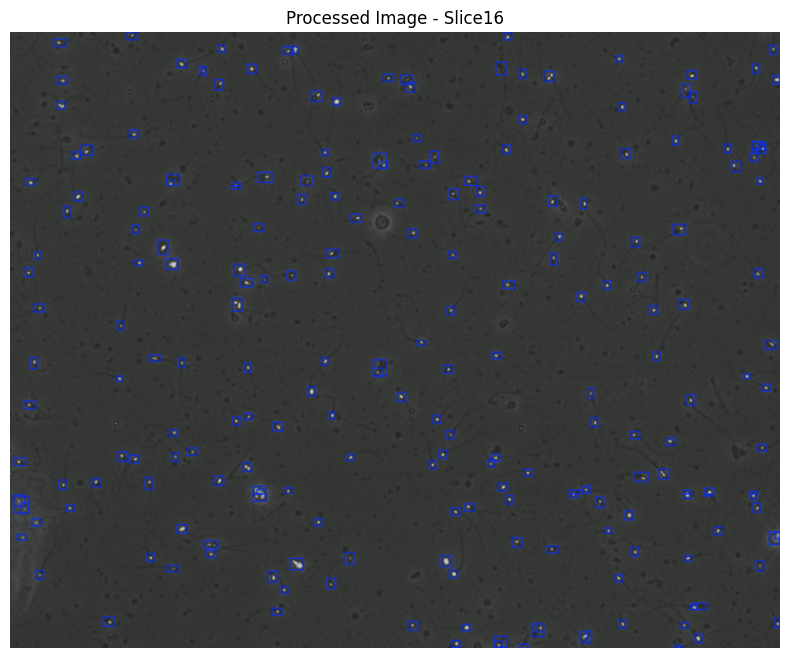

Combined image saved at: output_results\processed_slice16.jpg


In [7]:
# Import necessary libraries
import os
import cv2
import numpy as np
from ultralytics import RTDETR
import matplotlib.pyplot as plt

# Ensure matplotlib plots inline in Jupyter
%matplotlib inline

# Step 1: Load the model
# Replace 'bestRefinedAABB.pt' with the path to your model
model = RTDETR('bestRefinedAABB.pt')

# Step 2: Define the input image path
# Replace '1aviframe0.jpg' with your input image path
input_path = '1aviframe0.jpg'

# Step 3: Choose the slicing option
# Options: 'standard', 'slice4', 'slice16'
slicing_option = 'slice16'  # Change this as needed

# Output directory setup
output_base_dir = 'output_results'
os.makedirs(output_base_dir, exist_ok=True)

# Function to display images in Jupyter notebook
def display_image(image, title='Image'):
    # Convert BGR to RGB for correct color display
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(12, 8))
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.title(title)
    plt.show()

# Function to run inference on an image and return the result image
def run_inference_on_image(image_path, save_dir):
    # Run inference
    results = model.predict(
        source=image_path,
        save=True,
        save_txt=True,
        save_frames=True,
        show_labels=False,
        show_conf=True,
        save_conf=True,
        project=save_dir,
        name='.',
        exist_ok=True
    )
    # The processed image is saved in the save_dir with the same name
    processed_image_path = os.path.join(save_dir, os.path.basename(image_path))
    processed_image = cv2.imread(processed_image_path)
    return processed_image

# Step 4: Process the image based on the slicing option
if slicing_option == 'standard':
    # Run inference on the whole image
    save_dir = os.path.join(output_base_dir, 'standard')
    os.makedirs(save_dir, exist_ok=True)
    processed_image = run_inference_on_image(input_path, save_dir)
    if processed_image is not None:
        # Display the processed image
        display_image(processed_image, title='Processed Image - Standard')
    else:
        print("Error: Processed image could not be loaded.")

elif slicing_option in ['slice4', 'slice16']:
    # Determine grid size
    grid_sizes = {'slice4': (2, 2), 'slice16': (4, 4)}
    rows, cols = grid_sizes[slicing_option]

    # Desired output size for each slice (resize to this size before inference)
    output_size = (640, 480)  # Adjust as needed

    # Read the input image
    image = cv2.imread(input_path)
    if image is None:
        print(f"Error: Unable to load image at {input_path}")
    else:
        # Get image dimensions
        height, width = image.shape[:2]
        slice_height = height // rows
        slice_width = width // cols

        # Directories to save slices and processed slices
        slices_dir = os.path.join(output_base_dir, 'slices')
        processed_slices_dir = os.path.join(output_base_dir, 'processed_slices')
        os.makedirs(slices_dir, exist_ok=True)
        os.makedirs(processed_slices_dir, exist_ok=True)

        # Lists to hold processed slices and their original sizes
        processed_slices = []
        original_sizes = []
        slice_num = 1  # Start from 1 for consistent naming

        for i in range(rows):
            row_slices = []
            for j in range(cols):
                # Calculate slice coordinates
                y_start = i * slice_height
                y_end = (i + 1) * slice_height if i < rows - 1 else height
                x_start = j * slice_width
                x_end = (j + 1) * slice_width if j < cols - 1 else width

                # Extract slice
                slice_img = image[y_start:y_end, x_start:x_end]
                original_size = (slice_img.shape[1], slice_img.shape[0])  # (width, height)
                original_sizes.append(original_size)

                # Resize the slice to the desired output size
                resized_slice = cv2.resize(slice_img, output_size, interpolation=cv2.INTER_AREA)

                # Save resized slice image
                slice_filename = f'slice_{slice_num:02d}.jpg'
                slice_path = os.path.join(slices_dir, slice_filename)
                cv2.imwrite(slice_path, resized_slice)

                # Run inference on the resized slice
                slice_save_dir = os.path.join(processed_slices_dir, f'slice_{slice_num:02d}')
                os.makedirs(slice_save_dir, exist_ok=True)
                processed_resized_slice = run_inference_on_image(slice_path, slice_save_dir)

                if processed_resized_slice is not None:
                    # Resize processed slice back to original slice size
                    processed_slice = cv2.resize(
                        processed_resized_slice,
                        original_size,
                        interpolation=cv2.INTER_AREA
                    )
                    row_slices.append(processed_slice)
                else:
                    print(f"Error: Processed slice {slice_num} could not be loaded.")
                    # Use original slice as fallback (resized back to original size)
                    fallback_slice = cv2.resize(resized_slice, original_size, interpolation=cv2.INTER_AREA)
                    row_slices.append(fallback_slice)

                slice_num += 1

            # Concatenate slices horizontally to form a row
            if row_slices:
                row_image = np.hstack(row_slices)
                processed_slices.append(row_image)

        # Concatenate all rows vertically to form the combined image
        if processed_slices:
            combined_image = np.vstack(processed_slices)

            # Save and display the combined image
            combined_image_path = os.path.join(output_base_dir, f'processed_{slicing_option}.jpg')
            cv2.imwrite(combined_image_path, combined_image)
            display_image(combined_image, title=f'Processed Image - {slicing_option.capitalize()}')
            print(f"Combined image saved at: {combined_image_path}")
        else:
            print("Error: No processed slices available to combine.")

else:
    print(f"Error: Invalid slicing option '{slicing_option}'. Please choose 'standard', 'slice4', or 'slice16'.")
